In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install split-folders
import splitfolders
splitfolders.ratio('../input/alzheimer-mri-dataset/Dataset', output="output", seed=1345, ratio=(.8, 0.1,0.1)) 

Copying files: 6400 files [00:30, 212.52 files/s]


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from keras import layers
import matplotlib.image as img
%matplotlib inline

2024-09-19 14:01:13.312859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 14:01:13.312988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 14:01:13.438743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import numpy as np
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Flatten, Dense, AveragePooling2D
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from keras.optimizers import Adam, Adamax
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import math
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [5]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
train_path = r"/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train"
test_path = r"/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test"
batch_s = 32
img_size= (128,128)
mode = "rgb"

In [7]:
def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df


In [8]:
train_df = df_maker(train_path)

In [9]:
test_df = df_maker(test_path)

In [10]:
all_data = pd.concat([train_df,test_df])

In [11]:
train_df

,file_paths,labels
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
...,...,...
5116,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5117,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5118,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
5119,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented


In [12]:
all_data

,file_paths,labels
0,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
1,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
2,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
3,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
4,/kaggle/input/alzheimers-dataset-4-class-of-im...,ModerateDemented
...,...,...
1274,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1275,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1276,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented
1277,/kaggle/input/alzheimers-dataset-4-class-of-im...,MildDemented


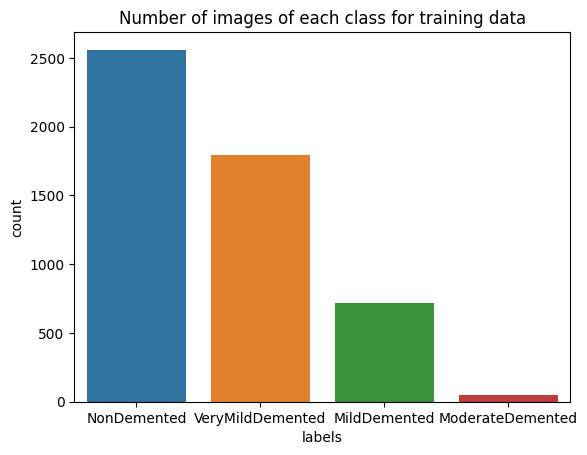

In [13]:
train_count_df = train_df.labels.value_counts().reset_index()
sns.barplot(data=train_count_df,x="labels",y="count")
plt.title("Number of images of each class for training data")
plt.show()

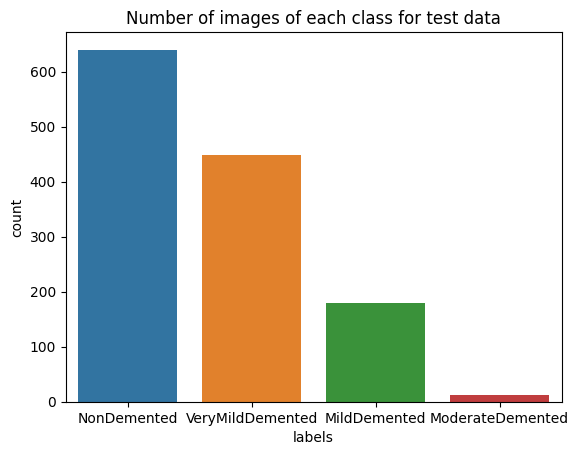

In [14]:
test_count_df = test_df.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for test data")
plt.show()

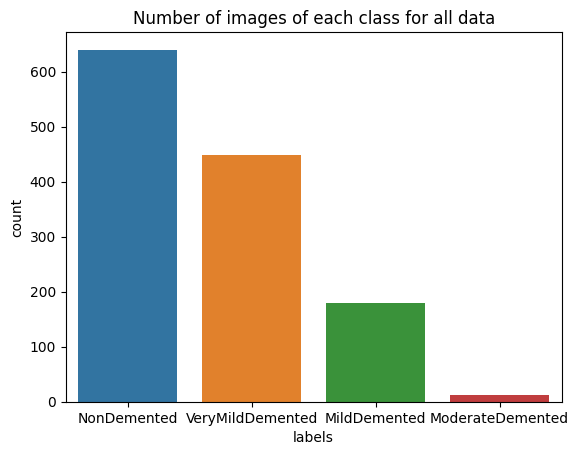

In [15]:
data_count_df = all_data.labels.value_counts().reset_index()
sns.barplot(data=test_count_df,x="labels",y="count")
plt.title("Number of images of each class for all data")
plt.show()

In [16]:
data_count_df

,labels,count
0,NonDemented,3200
1,VeryMildDemented,2240
2,MildDemented,896
3,ModerateDemented,64


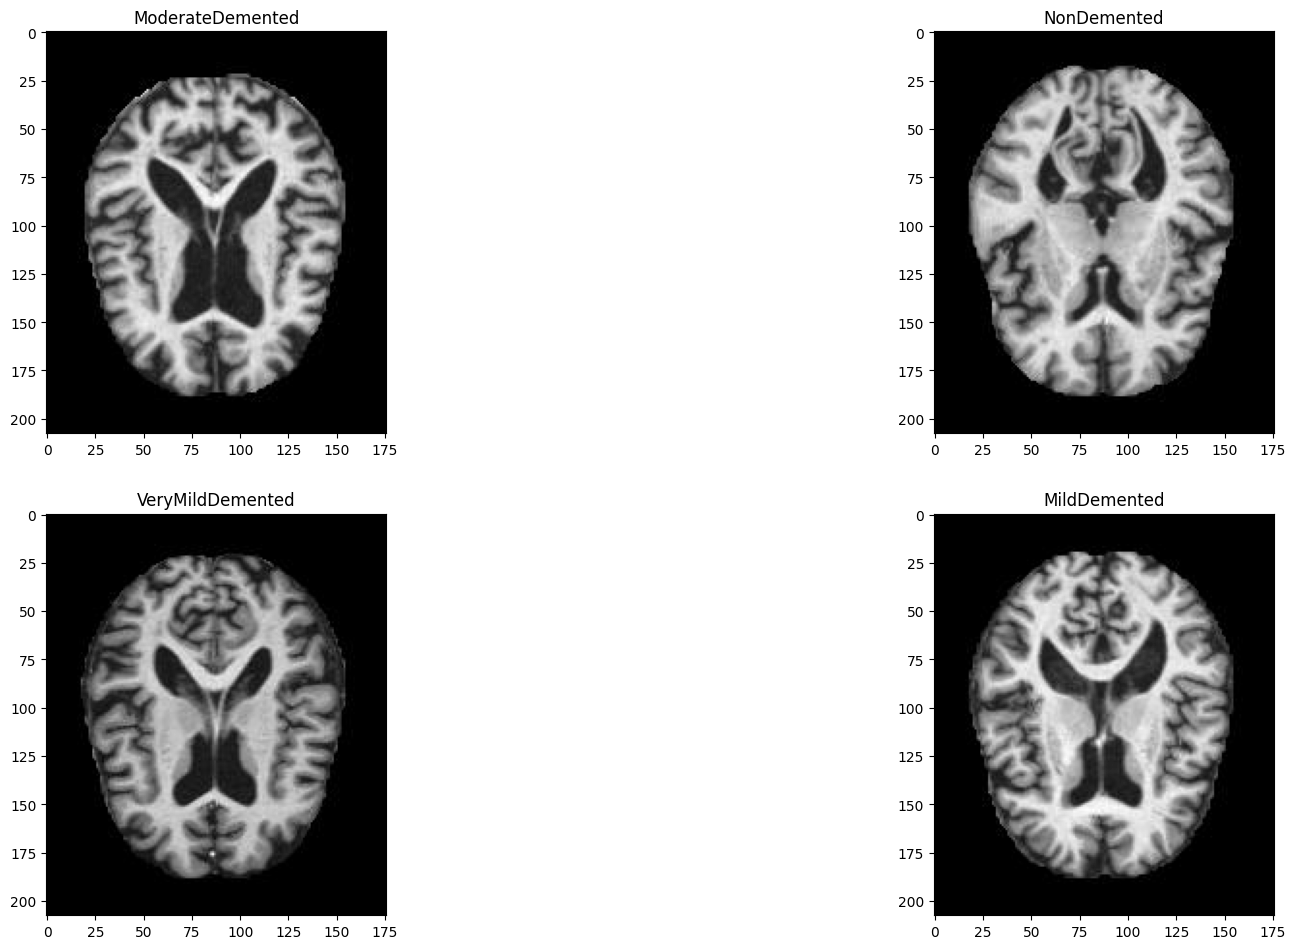

In [17]:
class_dirs = os.listdir(train_path)
plt.figure(figsize=(21, 24))
for i in range(len(class_dirs)):
    plt.subplot(4,2,i+1)
    img_path = f"{train_path}/{class_dirs[i]}/{os.listdir(f'{train_path}/{class_dirs[i]}')[0]}"
    img = plt.imread(img_path)/255
    plt.title(class_dirs[i])
    plt.imshow(img,cmap="gray")

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()
data_generator = datagen.flow_from_dataframe(
    all_data,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    batch_size=batch_s,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 6400 validated image filenames belonging to 4 classes.


In [19]:
data_generator.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [20]:
data_imgs=np.concatenate([next(data_generator)[0] for i in range(data_generator.__len__())])
data_labels=np.concatenate([next(data_generator)[1] for i in range(data_generator.__len__())])

In [21]:
data_imgs = data_imgs.reshape(-1,128,128,3)

In [22]:
train_imgs, test_imgs, train_labels,test_labels = train_test_split(data_imgs,data_labels,  train_size= 0.8, shuffle= True, random_state= 7,stratify=data_labels)

In [23]:
test_imgs, val_imgs, test_labels,val_labels = train_test_split(test_imgs,test_labels,  train_size= 0.5, shuffle= True, random_state= 7,stratify= test_labels)

In [24]:
from tensorflow.keras import backend as K
def ReplacingReLUX(x):
    #return (0.1524*(x**2) + 0.5*x + 0.409)
    #return tf.maximum(0.05 * x, x) 
    return 0.1524 * tf.square(x) + 0.5 * x + 0.409

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128,128, 3)))

model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [26]:
model.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.001), metrics=["accuracy","AUC"])
early_stoping = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3)

In [27]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0

In [28]:
hist = model.fit(
    train_imgs,train_labels,
    epochs = 50,
    validation_data = [val_imgs,val_labels],
    batch_size=batch_s,
    callbacks = [early_stoping]
)

Epoch 1/50


2024-09-19 14:02:29.515344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1726754552.892049     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 [==============================] - 9s 15ms/step - loss: 1.1821 - accuracy: 0.5004 - auc: 0.8026 - val_loss: 1.1998 - val_accuracy: 0.5031 - val_auc: 0.8086
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 0.9269 - accuracy: 0.5559 - auc: 0.8372 - val_loss: 1.2189 - val_accuracy: 0.5000 - val_auc: 0.7861
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 0.8640 - accuracy: 0.5818 - auc: 0.8574 - val_loss: 0.9663 - val_accuracy: 0.5141 - val_auc: 0.8409
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 0.8322 - accuracy: 0.6107 - auc: 0.8693 - val_loss: 0.9975 - val_accuracy: 0.5234 - val_auc: 0.8469
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 0.7792 - accuracy: 0.6355 - auc: 0.8863 - val_loss: 0.8771 - val_accuracy: 0.6062 - val_auc: 0.8679
Epoch 6/50
160/160 [==============================] - 2s 11ms/step - loss: 0.7354 - accuracy: 0.6699 - auc: 0.8997 - val_loss: 0.6976 - 

In [29]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

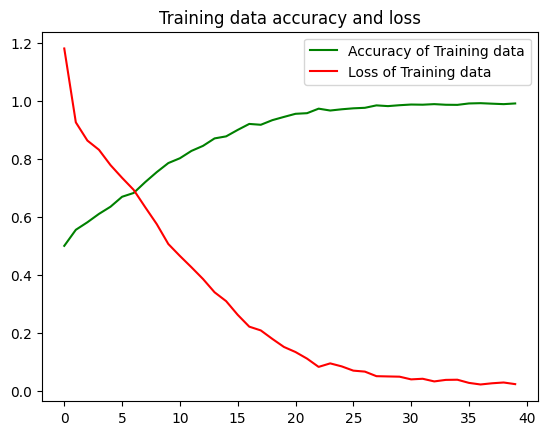

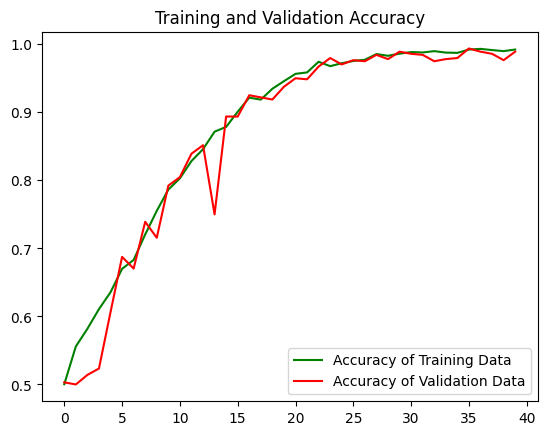

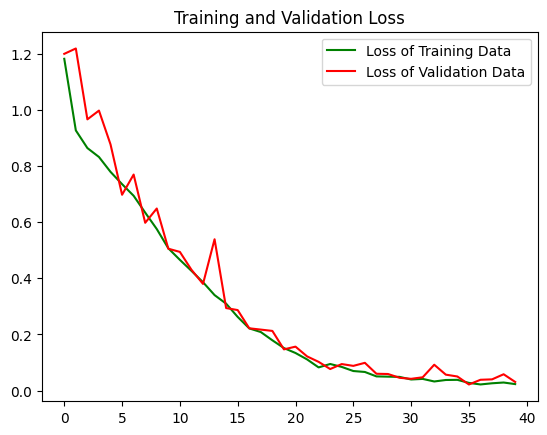

<Figure size 640x480 with 0 Axes>

In [30]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [31]:
model.evaluate(test_imgs, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 0.0425 - accuracy: 0.9828 - auc: 0.9989


[0.042473725974559784, 0.9828125238418579, 0.998881459236145]

In [32]:
predictions = model.predict(test_imgs) 
y_pred = np.argmax(predictions, axis = 1)
y_true = np.argmax(test_labels, axis = 1)
print(classification_report(y_true,y_pred))

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       1.00      1.00      1.00         7
           2       0.99      0.98      0.98       320
           3       0.97      0.99      0.98       224

    accuracy                           0.98       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.98      0.98      0.98       640



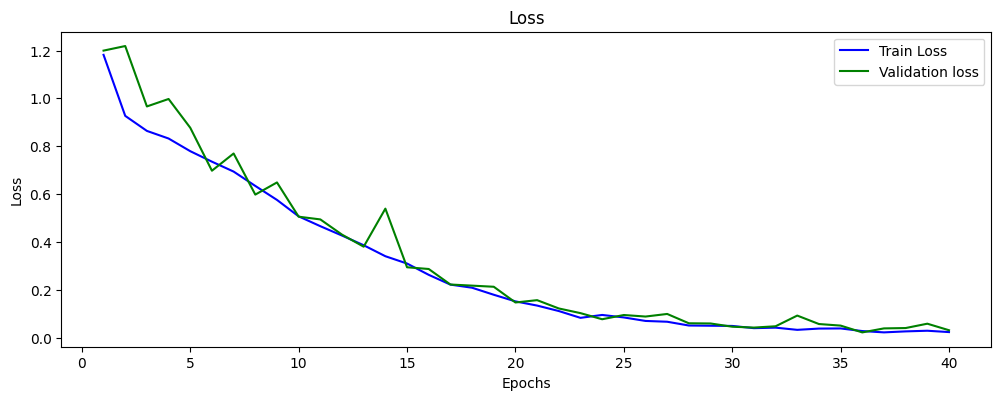

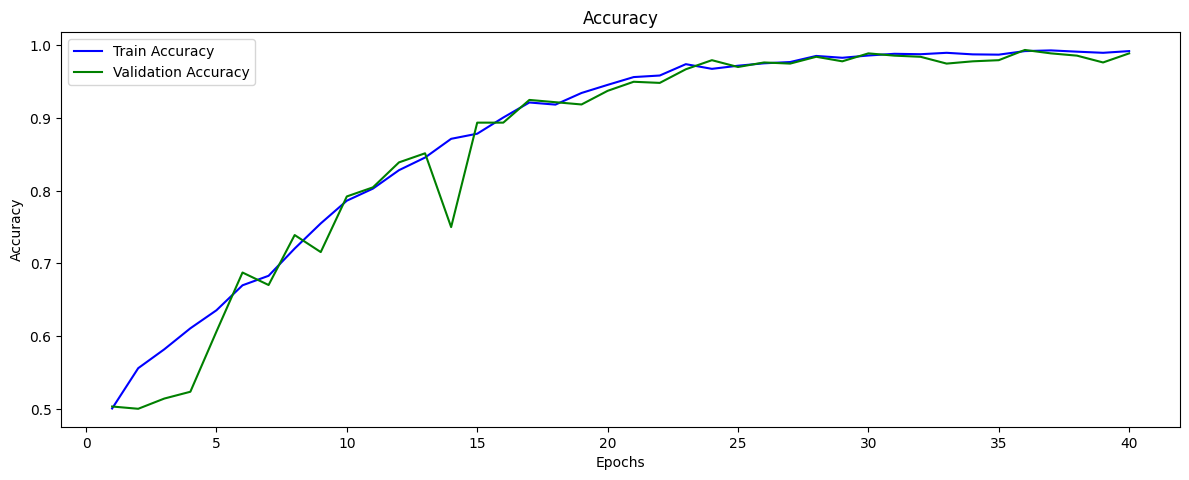

In [33]:
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

epochs = [i+1 for i in range(len(train_acc))]

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_loss,'b',label="Train Loss")
plt.plot(epochs,val_loss,'g',label="Validation loss")
plt.title("Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(figsize=(12,9))
plt.subplot(2,1,1)
plt.plot(epochs,train_acc,'b',label="Train Accuracy")
plt.plot(epochs,val_acc,'g',label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [34]:
model_HE = tf.keras.models.Sequential()
model_HE.add(tf.keras.layers.Rescaling(1./255, input_shape=(128,128, 3)))
model_HE.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',kernel_initializer="he_normal"))
model_HE.add(tf.keras.layers.Lambda(ReplacingReLUX))
model_HE.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))


model_HE.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',kernel_initializer="he_normal"))
model_HE.add(tf.keras.layers.Lambda(ReplacingReLUX))
model_HE.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))

model_HE.add(tf.keras.layers.Dropout(0.20))

model_HE.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',kernel_initializer="he_normal"))
model_HE.add(tf.keras.layers.Lambda(ReplacingReLUX))
model_HE.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2)))

model_HE.add(tf.keras.layers.Dropout(0.25))
model_HE.add(tf.keras.layers.Flatten())
model_HE.add(tf.keras.layers.Dense(128,kernel_initializer="he_normal"))
model_HE.add(tf.keras.layers.Lambda(ReplacingReLUX))
model_HE.add(tf.keras.layers.Dense(64))
model_HE.add(tf.keras.layers.Lambda(ReplacingReLUX))
          
model_HE.add(tf.keras.layers.Dense(4,"softmax"))
    
model_HE.compile(loss="categorical_crossentropy", optimizer=Adamax(learning_rate=0.001), metrics=["accuracy","AUC"])

In [35]:
model_HE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 lambda (Lambda)             (None, 128, 128, 16)      0         
                                                                 
 average_pooling2d (Average  (None, 64, 64, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 lambda_1 (Lambda)           (None, 64, 64, 32)        0         
                                                      

In [36]:
hist_HE = model_HE.fit(
    train_imgs,train_labels,
    epochs = 100,
    validation_data = [val_imgs,val_labels],
    batch_size=batch_s,
    callbacks = [early_stoping]
)

Epoch 1/100


2024-09-19 14:03:50.763062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


160/160 [==============================] - 5s 20ms/step - loss: 12.8596 - accuracy: 0.4648 - auc: 0.7146 - val_loss: 1.1473 - val_accuracy: 0.3500 - val_auc: 0.7549
Epoch 2/100
160/160 [==============================] - 2s 14ms/step - loss: 1.0395 - accuracy: 0.5006 - auc: 0.7888 - val_loss: 1.0535 - val_accuracy: 0.4375 - val_auc: 0.7668
Epoch 3/100
160/160 [==============================] - 2s 14ms/step - loss: 1.0314 - accuracy: 0.4979 - auc: 0.7929 - val_loss: 1.0668 - val_accuracy: 0.3719 - val_auc: 0.7614
Epoch 4/100
160/160 [==============================] - 2s 14ms/step - loss: 1.0250 - accuracy: 0.5027 - auc: 0.7964 - val_loss: 1.0795 - val_accuracy: 0.3578 - val_auc: 0.7604
Epoch 5/100
160/160 [==============================] - 2s 14ms/step - loss: 1.0157 - accuracy: 0.5211 - auc: 0.8016 - val_loss: 1.0376 - val_accuracy: 0.5031 - val_auc: 0.7915
Epoch 6/100
160/160 [==============================] - 2s 13ms/step - loss: 1.0149 - accuracy: 0.5146 - auc: 0.8024 - val_loss: 1.0

In [37]:
get_ac = hist_HE.history['accuracy']
get_los = hist_HE.history['loss']
val_acc = hist_HE.history['val_accuracy']
val_loss = hist_HE.history['val_loss']

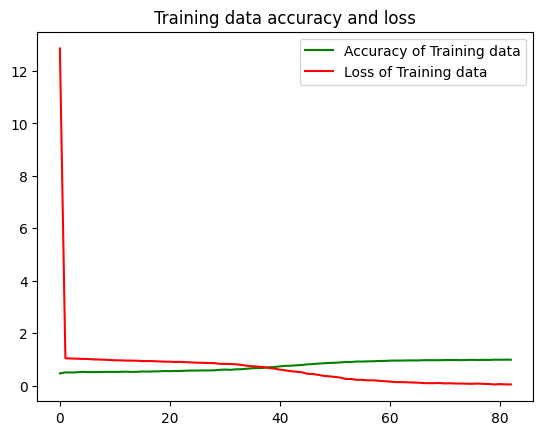

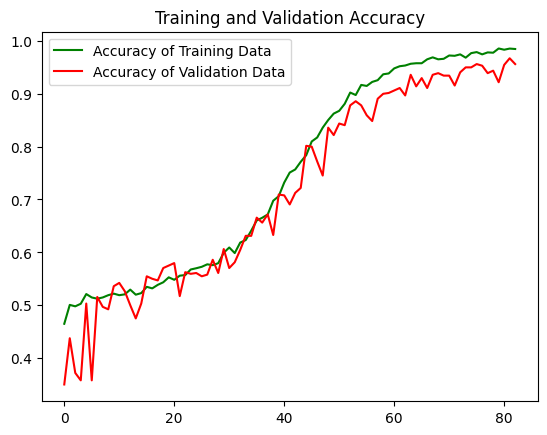

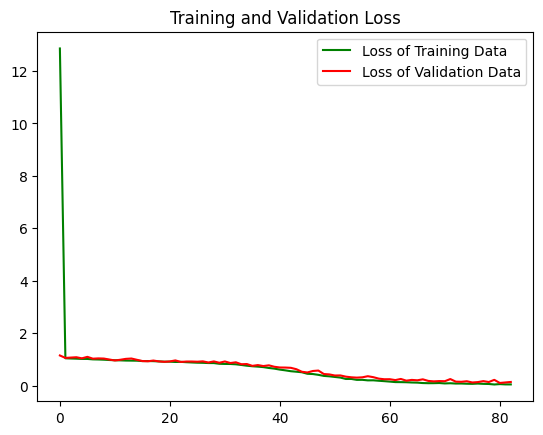

<Figure size 640x480 with 0 Axes>

In [38]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label='Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label='Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label='Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label='Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, get_los, 'g', label='Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label='Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [39]:
model_HE.evaluate(test_imgs,test_labels)

20/20 [==============================] - 0s 6ms/step - loss: 0.1184 - accuracy: 0.9703 - auc: 0.9962


[0.1184329017996788, 0.9703124761581421, 0.996235728263855]

In [40]:
predictions = model_HE.predict(test_imgs) 
y_pred = np.argmax(predictions, axis = 1)
y_true = np.argmax(test_labels, axis = 1)
print(classification_report(y_true,y_pred))

20/20 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        89
           1       1.00      1.00      1.00         7
           2       0.99      0.97      0.98       320
           3       0.95      0.98      0.96       224

    accuracy                           0.97       640
   macro avg       0.97      0.98      0.97       640
weighted avg       0.97      0.97      0.97       640



In [41]:
model_HE.save("HE_Friendly_tensorflow.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
def get_Params(model):
    lenModel = len(model_HE.layers)
    layer_ = model.layers
    for i in range(lenModel):
        if 'conv2d' in layer_[i].name:
            print(f'{i} conv2d')
        elif 'lambda' in layer_[i].name:
            print(f'{i} activation function')
        elif 'average_pooling2d' in layer_[i].name:
            print(f'{i} pooling')
        elif 'dropout' in layer_[i].name:
            print(f'{i} dropout')
        elif 'flatten' in layer_[i].name:
            print(f'{i} flatten')
        elif 'dense' in layer_[i].name:
            print(f'{i} dense')
        else:
            print(f'{i} other')
     

In [43]:
get_Params(model_HE)

0 other
1 conv2d
2 activation function
3 pooling
4 conv2d
5 activation function
6 pooling
7 dropout
8 conv2d
9 activation function
10 pooling
11 dropout
12 flatten
13 dense
14 activation function
15 dense
16 activation function
17 dense


In [44]:
w_conv0, b_conv0 = model_HE.layers[1].get_weights()
w_conv1, b_conv1 = model_HE.layers[4].get_weights()
w_conv2, b_conv2 = model_HE.layers[8].get_weights()
w_dense0, b_dense0 = model_HE.layers[13].get_weights()
w_dense1, b_dense1 = model_HE.layers[15].get_weights()
w_dense2, b_dense2 = model_HE.layers[17].get_weights()

In [45]:
class Input:
    def __init__(self, Input, Key):
        if len(Input.shape) < 3:
            raise ValueError
        elif len(Input.shape) == 3:
            self.Input = torch.tensor(Input).unsqueeze(dim=0)
        else:
            self.Input = torch.tensor(Input)
        self.K = torch.tensor(Key)

    def EncX(self):
        x00 = torch.tensor(self.Input, dtype = torch.float32)
        x01 = torch.rand(*x00.shape, dtype = torch.float32)
        x10 = torch.zeros_like(x00)
        x11 = torch.rand(*x00.shape, dtype = torch.float32)
        dimx = len(x00.shape)
        print(dimx)
        x_stack00 = torch.stack((x00, x10), dim = dimx)
        print("x_stack00: ",x_stack00.shape)
        x_stack11 = torch.stack((x01, x11), dim = dimx)
        print("x_stack11: ",x_stack11.shape)
        OutputX = torch.stack((x_stack00, x_stack11), dim = dimx+1)
        print("before x Ks: ",OutputX.shape)
        Kd = torch.inverse(self.K)
        Output_Enc = torch.matmul(torch.matmul(self.K, OutputX), Kd)
        print('output_enc: ', Output_Enc.shape)
        return Output_Enc

    def value(self):
        return self.Input

In [46]:
import torch

In [47]:
K = np.random.uniform(0, 1, (2, 2)).astype('float32')
Kd = np.linalg.inv(K)
k = torch.tensor(K)
kd = k.inverse()
one = torch.ones(2,2)
one[1, 0] =0
oneE = k @ one @ kd

In [48]:
os.mkdir('/kaggle/working/test')

In [49]:
def transfer_label(path):
    if ("/Mild Impairment/" in path):
        return 1
    elif ("/Moderate Impairment/" in path):
        return 2
    elif ("/No Impairment/" in path):
        return 3
    else:
        return 4

In [50]:
import cv2
from PIL import Image
filelist = []
x_test = []
for dirname, _, filenames in os.walk('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
for i in filelist[:]:
    img = cv2.imread(i)
    numpying = np.array(img)
    x_test.append(numpying)

In [51]:
print(len(x_test))

1279


In [52]:
x1 = x_test[0]/255
K_ = torch.tensor(K)
Xtest = Input(x1, K_)
Xtest_ = Xtest.EncX()
Xtest_.shape, x1.shape

4
x_stack00:  torch.Size([1, 128, 128, 3, 2])
x_stack11:  torch.Size([1, 128, 128, 3, 2])
before x Ks:  torch.Size([1, 128, 128, 3, 2, 2])
output_enc:  torch.Size([1, 128, 128, 3, 2, 2])


/tmp/ipykernel_34/2563993235.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.K = torch.tensor(Key)
/tmp/ipykernel_34/2563993235.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x00 = torch.tensor(self.Input, dtype = torch.float32)


(torch.Size([1, 128, 128, 3, 2, 2]), (128, 128, 3))

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0_weight = nn.Parameter(torch.tensor(w_conv0.T))
        self.conv0_bias = nn.Parameter(torch.tensor(b_conv0))
        self.conv1_weight = nn.Parameter(torch.tensor(w_conv1.T))
        self.conv1_bias = nn.Parameter(torch.tensor(b_conv1))
        self.conv2_weight = nn.Parameter(torch.tensor(w_conv2.T))
        self.conv2_bias = nn.Parameter(torch.tensor(b_conv2))
        
        self.dense0_weight = nn.Parameter(torch.tensor(w_dense0.T))
        self.dense0_bias = nn.Parameter(torch.tensor(b_dense0))
        self.dense1_weight = nn.Parameter(torch.tensor(w_dense1.T))
        self.dense1_bias = nn.Parameter(torch.tensor(b_dense1))
        self.dense2_weight = nn.Parameter(torch.tensor(w_dense2.T))
        self.dense2_bias = nn.Parameter(torch.tensor(b_dense2))
#     def ActFunc(self, W, layer_='ReplaceReLU'):
#         if not isinstance(W, torch.Tensor):
#             W = torch.tensor(W)  # Convert to tensor if not already
#         return torch.max(0.05 * W, W)
    def ActFunc(self, W, layer_ = 'ReplaceReLU'):
        lenW = len(W[0].shape)
        w00 = torch.stack((W[0], W[2]), dim = lenW)
        w11 = torch.stack((W[1], W[3]), dim = lenW)
        W_ = torch.stack((w00, w11), dim = lenW+1)
        print("W_: ", W_.shape)
        if layer_ == "other":
            return W_
        else:
            #return torch.max( 0.05 * W_, W_)
            return 0.1524 * W_ * W_ + 0.5 * W_ + 0.409
    def Average_Pooling(self, inputi):
#         input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
#                                         inputi.shape[2], inputi.shape[3],-1)
#         inputXa = list(input_reshape.permute(4, 0,1,2, 3))
#         inputXb = torch.stack(inputXa)
#         print("Inputb: ",inputXb.shape)
        input_reshape_ = inputi.view( inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3],-1)
        inputXc = list(input_reshape_.permute(3, 0,1,2))
        inputX_ = torch.stack(inputXc)
        print(inputX_.shape)
        poolOut = F.avg_pool2d(inputX_, kernel_size=(2, 2))
        print("Pool Out: ",poolOut.shape)
        out_reshape = poolOut.view(1, poolOut.shape[1], poolOut.shape[2], poolOut.shape[3], 2,2)
        print("Out_reshape: ",out_reshape.shape)
        return out_reshape
    def Compute_Enc(self, inputi, weight, bias, oneE, layer = "Conv2d"):
        biasE = list(oneE.view(-1, 1) * bias)
        print(len(biasE))
        if len(inputi.shape) == 4:
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1], -1)
            inputX = list(input_reshape.permute(2, 0, 1))
        elif len(inputi.shape) == 5:
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], -1)
            inputX = list(input_reshape.permute(3, 2,1,0))
        elif len(inputi.shape) == 6 and layer == 'Conv2d1':
            print(inputi.shape)
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3], -1)
            print("Input after view: ", input_reshape.shape)
            inputX = list(input_reshape.permute(4, 0, 3 , 1, 2))
            print("InputX after permutue: ", len(inputX))
        elif len(inputi.shape) == 6 and layer == 'Conv2d2':
            print("Input shape: ", inputi.shape)
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3], -1)
            print("Input after view:" ,input_reshape.shape)
            inputX = list(input_reshape.permute(4, 0, 1,2,3))
            print("Len of inputX",len(inputX))
        else:
            raise ValueError
            print("Kiểm tra shape đầu vào")
        if layer == "Conv2d1":
            print("Weight: ", weight.shape)
            lstOut = list(map(lambda X, b, w=weight:
                              F.conv2d(X, w, b, padding='same'), inputX, biasE))
            print("List Out after Conv: ", len(lstOut))
        elif layer == "Conv2d2":
            lstOut = list(map(lambda X, b, w=weight:
                              F.conv2d(X, w, b, padding='same'), inputX, biasE))
        elif layer == "Dense":
            lstOut = list(map(lambda X, b, w=weight:
                              F.linear(X, w, b), inputX, biasE))
        return (lstOut)
    def forward(self, x, oneE):
        print(x.shape)
        out = self.Compute_Enc(x, self.conv0_weight, self.conv0_bias, oneE, layer = 'Conv2d1')
        print("Out after Conv1 before ActFunc: ", len(out))
        out = self.ActFunc(out)
        print("Out after ActFunc: ", out.shape)
        print("Conv weight : ",self.conv0_weight.shape)
        print("Conv bias : ",self.conv0_bias.shape)
        out = self.Average_Pooling(out)
        print("Out after av1: ", out.shape)
        out = self.Compute_Enc(out, self.conv1_weight, self.conv1_bias, oneE, layer = 'Conv2d2')
        out = self.ActFunc(out)
        print("Out after Conv2: ", out.shape)
        print("Conv weight : ",self.conv1_weight.shape)
        print("Conv bias : ",self.conv1_bias.shape)
        out = self.Average_Pooling(out)
        print("Out after av2: ", len(out))
        out = self.Compute_Enc(out, self.conv2_weight, self.conv2_bias, oneE, layer = 'Conv2d2')
        out = self.ActFunc(out)
        out = self.Average_Pooling(out)
        print("Out after av3: ", len(out))
        print("Out before permuting: ", len(out))
        out = out.permute(0,3,2,1,4,5)
        print("Out after permute before flatten: ", out.shape)
        out = torch.flatten(out, 1, -3)
        print("Shape out : ", out.shape)
        print("Dense weight : ",self.dense0_weight.shape)
        print("Dense bias : ",self.dense0_bias.shape)
        out = self.Compute_Enc(out, self.dense0_weight, self.dense0_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        out = self.Compute_Enc(out, self.dense1_weight, self.dense1_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        out = self.Compute_Enc(out, self.dense2_weight, self.dense2_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        return out

In [54]:
net = Net()
pred_Enc = net.forward(Xtest_, oneE)

torch.Size([1, 128, 128, 3, 2, 2])
4
torch.Size([1, 128, 128, 3, 2, 2])
Input after view:  torch.Size([1, 128, 128, 3, 4])
InputX after permutue:  4
Weight:  torch.Size([16, 3, 3, 3])
List Out after Conv:  4
Out after Conv1 before ActFunc:  4
W_:  torch.Size([1, 16, 128, 128, 2, 2])
Out after ActFunc:  torch.Size([1, 16, 128, 128, 2, 2])
Conv weight :  torch.Size([16, 3, 3, 3])
Conv bias :  torch.Size([16])
torch.Size([4, 16, 128, 128])
Pool Out:  torch.Size([4, 16, 64, 64])
Out_reshape:  torch.Size([1, 16, 64, 64, 2, 2])
Out after av1:  torch.Size([1, 16, 64, 64, 2, 2])
4
Input shape:  torch.Size([1, 16, 64, 64, 2, 2])
Input after view: torch.Size([1, 16, 64, 64, 4])
Len of inputX 4
W_:  torch.Size([1, 32, 64, 64, 2, 2])
Out after Conv2:  torch.Size([1, 32, 64, 64, 2, 2])
Conv weight :  torch.Size([32, 16, 3, 3])
Conv bias :  torch.Size([32])
torch.Size([4, 32, 64, 64])
Pool Out:  torch.Size([4, 32, 32, 32])
Out_reshape:  torch.Size([1, 32, 32, 32, 2, 2])
Out after av2:  1
4
Input sha

In [55]:
print(pred_Enc.shape)

torch.Size([1, 4, 2, 2])


In [56]:
pred_Dec = kd @ pred_Enc @ k
pred_Dec.shape

torch.Size([1, 4, 2, 2])

In [57]:
pred_Dec[0, -10:, 0, 0]

tensor([3.3532e+10, 2.7122e+12, 4.2925e+12, 3.0050e+12],
       grad_fn=<SelectBackward0>)

In [58]:
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)  # Use .values to get the tensor output
    return exp_x / torch.sum(exp_x, dim=1, keepdim=True)

In [59]:
pred_HE_after_Dec = softmax(pred_Dec)
print(pred_HE_after_Dec)

tensor([[[[0., 0.],
          [1., 1.]],

         [[0., 0.],
          [0., 0.]],

         [[1., 1.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]], grad_fn=<DivBackward0>)


In [60]:
pred_HE_after_Dec[0, -10:, 0, 0]

tensor([0., 0., 1., 0.], grad_fn=<SelectBackward0>)

In [61]:
x1 = x_test[0]
x1 = np.expand_dims(x1, axis=0)
pred = model_HE(x1)
print(pred)

tf.Tensor([[9.3531925e-03 7.7914319e-17 6.9536263e-01 2.9528415e-01]], shape=(1, 4), dtype=float32)


In [62]:
filelist[0]

'/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/No Impairment/20 (46).jpg'

In [63]:
def acc(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return float(correct)/y_true.shape[0]


In [64]:
model_HE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 lambda (Lambda)             (None, 128, 128, 16)      0         
                                                                 
 average_pooling2d (Average  (None, 64, 64, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 lambda_1 (Lambda)           (None, 64, 64, 32)        0         
                                                      

In [65]:
class InputAll:
    def __init__(self, Input, Key):
        if len(Input.shape) < 3:
            raise ValueError
        elif len(Input.shape) == 3:
            self.Input = torch.tensor(Input).unsqueeze(dim=0)
        else:
            self.Input = torch.tensor(Input)
        self.K = torch.tensor(Key)

    def EncX(self):
        x00 = torch.tensor(self.Input, dtype = torch.float32)
        x01 = torch.rand(*x00.shape, dtype = torch.float32)
        x10 = torch.zeros_like(x00)
        x11 = torch.rand(*x00.shape, dtype = torch.float32)
        dimx = len(x00.shape)
        x_stack00 = torch.stack((x00, x10), dim = dimx)
        x_stack11 = torch.stack((x01, x11), dim = dimx)
        OutputX = torch.stack((x_stack00, x_stack11), dim = dimx+1)
        Kd = torch.inverse(self.K)
        Output_Enc = torch.matmul(torch.matmul(self.K, OutputX), Kd)
        return Output_Enc

    def value(self):
        return self.Input

In [66]:
class AllNet(nn.Module):
    def __init__(self):
        super(AllNet, self).__init__()
        self.conv0_weight = nn.Parameter(torch.tensor(w_conv0.T))
        self.conv0_bias = nn.Parameter(torch.tensor(b_conv0))
        self.conv1_weight = nn.Parameter(torch.tensor(w_conv1.T))
        self.conv1_bias = nn.Parameter(torch.tensor(b_conv1))
        self.conv2_weight = nn.Parameter(torch.tensor(w_conv2.T))
        self.conv2_bias = nn.Parameter(torch.tensor(b_conv2))
        
        self.dense0_weight = nn.Parameter(torch.tensor(w_dense0.T))
        self.dense0_bias = nn.Parameter(torch.tensor(b_dense0))
        self.dense1_weight = nn.Parameter(torch.tensor(w_dense1.T))
        self.dense1_bias = nn.Parameter(torch.tensor(b_dense1))
        self.dense2_weight = nn.Parameter(torch.tensor(w_dense2.T))
        self.dense2_bias = nn.Parameter(torch.tensor(b_dense2))
    def ActFunc(self, W, layer_ = 'ReplaceReLU'):
        lenW = len(W[0].shape)
        w00 = torch.stack((W[0], W[2]), dim = lenW)
        w11 = torch.stack((W[1], W[3]), dim = lenW)
        W_ = torch.stack((w00, w11), dim = lenW+1)
        if layer_ == "other":
            return W_
        else:
            #return torch.max( 0.05 * W_, W_)
            return 0.1524 * torch.square(W_) + 0.5 * W_ + 0.409
    def Average_Pooling(self, inputi):
        input_reshape_ = inputi.view( inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3],-1)
        inputXc = list(input_reshape_.permute(3, 0,1,2))
        inputX_ = torch.stack(inputXc)
        poolOut = F.avg_pool2d(inputX_, kernel_size=(2, 2))
        out_reshape = poolOut.view(1, poolOut.shape[1], poolOut.shape[2], poolOut.shape[3], 2,2)
        return out_reshape
    def Compute_Enc(self, inputi, weight, bias, oneE, layer = "Conv2d"):
        biasE = list(oneE.view(-1, 1) * bias)
        if len(inputi.shape) == 4:
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1], -1)
            inputX = list(input_reshape.permute(2, 0, 1))
        elif len(inputi.shape) == 5:
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], -1)
            inputX = list(input_reshape.permute(3, 2,1,0))
        elif len(inputi.shape) == 6 and layer == 'Conv2d1':
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3], -1)
            inputX = list(input_reshape.permute(4, 0, 3 , 1, 2))
        elif len(inputi.shape) == 6 and layer == 'Conv2d2':
            input_reshape = inputi.view(inputi.shape[0], inputi.shape[1],
                                        inputi.shape[2], inputi.shape[3], -1)
            inputX = list(input_reshape.permute(4, 0, 1,2,3))
        else:
            raise ValueError
        if layer == "Conv2d1":
            lstOut = list(map(lambda X, b, w=weight:
                              F.conv2d(X, w, b, padding='same'), inputX, biasE))
        elif layer == "Conv2d2":
            lstOut = list(map(lambda X, b, w=weight:
                              F.conv2d(X, w, b, padding='same'), inputX, biasE))
        elif layer == "Dense":
            lstOut = list(map(lambda X, b, w=weight:
                              F.linear(X, w, b), inputX, biasE))
        return (lstOut)
    def forward(self, x, oneE):
        out = self.Compute_Enc(x, self.conv0_weight, self.conv0_bias, oneE, layer = 'Conv2d1')
        out = self.ActFunc(out)
        out = self.Average_Pooling(out)
        out = self.Compute_Enc(out, self.conv1_weight, self.conv1_bias, oneE, layer = 'Conv2d2')
        out = self.ActFunc(out)
        out = self.Average_Pooling(out)
        out = self.Compute_Enc(out, self.conv2_weight, self.conv2_bias, oneE, layer = 'Conv2d2')
        out = self.ActFunc(out)
        out = self.Average_Pooling(out)
        out = out.permute(0,3,2,1,4,5)
        out = torch.flatten(out, 1, -3)
        out = self.Compute_Enc(out, self.dense0_weight, self.dense0_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        out = self.Compute_Enc(out, self.dense1_weight, self.dense1_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        out = self.Compute_Enc(out, self.dense2_weight, self.dense2_bias, oneE, layer = 'Dense')
        out = self.ActFunc(out)
        return out

In [67]:
import cv2
from PIL import Image
filelist = []
x_test = []
for dirname, _, filenames in os.walk('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))
for i in filelist[:1000]:
    img = cv2.imread(i)
    numpying = np.array(img)
    x_test.append(numpying)

In [68]:
print(len(x_test))

1000


In [69]:
net_All = AllNet()
result = []
resultNoHE = []
for i in range(700):
    x1 = x_test[i]
    K_ = torch.tensor(K)
    x1_devide = x1/255
    Xtest = InputAll(x1_devide, K_)
    Xtest_ = Xtest.EncX()
    pred_Enc = net_All.forward(Xtest_, oneE)
    pred_Dec = kd @ pred_Enc @ k
    pred_HE_after_Dec = softmax(pred_Dec)
    array_pred = pred_HE_after_Dec[0, -10:, 0, 0].detach().numpy()
    result.append(array_pred)
    x1 = np.expand_dims(x1, axis=0)
    pred = model_HE(x1)
    pred_array = np.array(pred)
    resultNoHE.append(pred_array)
    

/tmp/ipykernel_34/2051188585.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.K = torch.tensor(Key)
/tmp/ipykernel_34/2051188585.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x00 = torch.tensor(self.Input, dtype = torch.float32)


In [70]:
import sys
x1 = x_test[0]
K_ = torch.tensor(K)
x1_devide = x1/255
xtest = InputAll(x1_devide, K_)
Xtest_ = Xtest.EncX()
print(sys.getsizeof(x_test[0]))
#print(x_test[0])
print(sys.getsizeof(Xtest_))
#print(Xtest_)

49296
80


/tmp/ipykernel_34/2051188585.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.K = torch.tensor(Key)
/tmp/ipykernel_34/2051188585.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x00 = torch.tensor(self.Input, dtype = torch.float32)


In [71]:
print(result[338])
print(resultNoHE[338])

[0. 0. 1. 0.]
[[1.4949947e-03 5.0797047e-11 9.9830699e-01 1.9799927e-04]]


In [72]:
predicted_labels = np.argmax(result, axis=-1).flatten()
true_labels = np.argmax(resultNoHE, axis=-1).flatten()
accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 90.71%
